In [1]:
%matplotlib inline

In [2]:
# import neurotree api python functions
from neurotree_api import get_investigator_path_len, get_neurotree_node_id_from_pmid, get_neurotree_node_info

# test the api functions
get_neurotree_node_info(4800)
node_id = get_neurotree_node_id_from_pmid(11483306)
print node_id
get_investigator_path_len(77014, 4800)
get_investigator_path_len(2218, 196)

None
{u'path2': [2715, 77014], u'pathcount': 2, u'stepstaken': 1, u'stepcount': 2, u'path1': [2715, 4800], u'name2': u'Richard C Gerkin', u'name1': u'Shreejoy J Tripathy', u'pid1': 77014, u'pid2': 4800, u'backonly': u'1'}
{u'path2': None, u'pathcount': None, u'stepstaken': 8, u'stepcount': None, u'path1': None, u'name2': u'Claude  Bernard', u'name1': u'Daniel L Alkon', u'pid1': 2218, u'pid2': 196, u'backonly': u'1'}


(None, None)

In [5]:
# load the saved objects from the pairwise CA1 author path search

import pickle

# Getting back the objects:
with open('objs.pickle') as f:
    path_len_mat, unique_neurotree_id_list, common_ancestor_list = pickle.load(f)

In [6]:
# Load the neuroelectro data dump.  
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer,Imputer
import pandas as pd
df = pd.read_csv('http://dev.neuroelectro.org/static/src/article_ephys_metadata_curated.csv',delimiter='\t')

In [7]:
# convert the pariwise path len matrix to a symmetric matrix
sym_path_len_mat = path_len_mat
sym_path_len_mat[np.tril_indices(45)] = 0
sym_path_len_mat = sym_path_len_mat + sym_path_len_mat.T

In [8]:
# sort the pairiwse math length matrix by similarity
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import leaders, fclusterdata, linkage, dendrogram, leaves_list

d = squareform(sym_path_len_mat, checks = False)
Z = linkage(d)
sorted_rows = leaves_list(Z)

sorted_node_id_list = [unique_neurotree_id_list[i] for i in sorted_rows.tolist()]
none_index = sorted_node_id_list.index(None)
del sorted_node_id_list[none_index]

sorted_author_names = [get_neurotree_node_info(int(node_id)) for node_id in sorted_node_id_list]
sorted_author_last_names = []
for n in sorted_author_names:
    if n and 'lastname' in n:
        sorted_author_last_names.append('%s, %s' % (n['lastname'], n['pid']))
    else:
        sorted_author_last_names.append('UNKN')

# sym_path_len_mat_sorted is the sorted path length distance matrix
elems = sorted_rows.tolist()
del elems[none_index]

new_order = elems
sym_path_len_mat_sorted = sym_path_len_mat[:, new_order][new_order]

In [9]:
# define a data frame for the symmetric path length distance matrix
path_df = pd.DataFrame(data = sym_path_len_mat_sorted, index = sorted_node_id_list, columns = sorted_node_id_list)

In [10]:
# map neuroelectro pubmed ids to neurotree node ids
neurotree_id_list = []
cell_type_name = 'Hippocampus CA1 pyramidal cell'
ca1_df = df[df['NeuronName'].isin([cell_type_name])]
ca1_df.head()

cell_match = df['NeuronName'].isin([cell_type_name])
pmid_list = list(set(df['Pmid'][cell_match]))

df['NeuroTreeID'] = np.zeros(len(df['Pmid']))

pmid_to_node_dict = {}

for index, row in ca1_df.iterrows():
    pmid = row['Pmid']
    node_id = get_neurotree_node_id_from_pmid(pmid)
    ca1_df.loc[index,'NeuroTreeID'] = node_id
#     asdfasf
#     neurotree_id_list.append(node_id)
#     pmid_to_node_dict[pmid] = node_id
# node_to_pmid_dict = {v: k for k, v in pmid_to_node_dict.items()}

26224869
None
26224869
None
24166578
6500
25628536
6909
25628536
6909
25628536
6909
25628536
6909
23536065
458
24399930
3776
22157122
2701
22279188
None
22367983
28749
22367983
28749
22423094
196
22423094
196
23177962
1484
23177962
1484
20014384
7764
20014384
7764
21160001
2613
21215795
9676
21215795
9676
21289178
42508
21593314
None
21635953
2534
22131424
2084
22171027
2492
19914331
7080
20421280
None
20510860
2223
20592204
None
20639007
81966
20646048
None
19103683
5164
19261881
455
19261881
455
19261881
455
19261881
455
19302151
50988
19675296
1404
19675296
1404
19675296
1404
19710327
5894
17991696
None
18353290
18036
18353290
18036
18674519
None
18683240
None
18683240
None
17202472
None
17291464
3355
17291464
3355
17715197
12460
17884930
3677
16481438
10162
16533575
None
16542781
None
16542781
None
16571755
None
16571755
None
16571755
None
16571755
None
16571755
None
15661817
None
16002454
1484
16192378
4810
16237175
9675
16237175
9675
16367774
28491
14645379
None
14645379
None
151

/home/stripathy/.local/lib/python2.7/site-packages/pandas/core/indexing.py:266: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/stripathy/.local/lib/python2.7/site-packages/pandas/core/indexing.py:426: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [11]:
new_df = ca1_df[['NeuroTreeID', 'LastAuthor', 'Pmid']]
new_df = new_df.drop_duplicates(['NeuroTreeID', 'LastAuthor'])

In [12]:
new_df.sort_values(by = ['NeuroTreeID', 'LastAuthor'])

,NeuroTreeID,LastAuthor,Pmid
1009,10080,Ramakers GM,12699792
804,10162,Wilcox KS,16481438
765,12460,Orser BA,17715197
1152,13466,Barish ME,10878106
580,1404,Chitwood RA,19675296
299,1484,Spruston N,23177962
976,1645,Baraban SC,15381293
1266,1651,Schwartzkroin PA,9120553
626,18036,Woodin MA,18353290
235,196,Bernard C,22423094


In [13]:
new_df['Connectedness'] = np.empty(len(new_df['Pmid']))
new_df['Connectedness'] = np.NAN
new_df.head()

for index, row in new_df.iterrows():
    pid = row['NeuroTreeID']
#     print pid
#     print pid in path_df.columns
    if pid in path_df.columns:
        num_inf = sum(path_df[pid].values == np.inf) + sum(np.isnan(path_df[pid].values))
        
        pct_inf = num_inf / (float(len(path_df.columns)) - 1)
        new_df.loc[index,'Connectedness'] = 1 - pct_inf
    else:
        new_df.loc[index,'Connectedness'] = np.nan

    #print np.isnan(row['node_id'])
#     if not new_df['node_id'].empty:
#         node_id = str(new_df['node_id'])
#         #print node_id
#         sum(path_df[node_id].values == np.inf) + sum(path_df[node_id].values == np.nan)

In [14]:
new_df = new_df.sort_values(by = ['Connectedness', 'NeuroTreeID', 'LastAuthor'], ascending = [0, 1, 1])

In [15]:
new_df.to_csv('ca1_pyr_auths.csv', index = False)

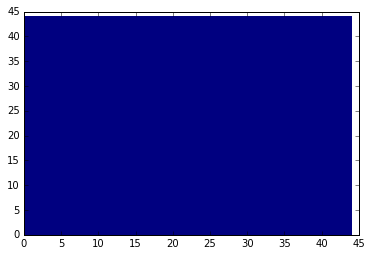

In [16]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
heatmap = ax.pcolor(path_df)

In [48]:
inds = new_df[new_df['Connectedness'] > .2]['NeuroTreeID']
valid_pmids = new_df[new_df['Connectedness'] > .2]['Pmid']
min_df = path_df.loc[inds,inds]
min_df[min_df > 20] = 20
min_df[np.isnan(min_df)] = 20
min_df

,1484,1645,2613,50988,6500,10080,10162,12460,13466,1404,...,5362,6909,7764,81966,9024,2534,3542,3677,5894,196
1484,0,6,3,2,8,7,7,7,6,2,...,9,9,5,14,5,11,2,5,12,8
1645,6,0,6,6,8,7,11,7,6,8,...,10,6,4,9,5,14,8,5,12,8
2613,3,6,0,3,8,5,8,7,7,2,...,10,9,7,12,5,12,3,5,12,9
50988,2,6,3,0,8,7,8,7,6,8,...,9,9,7,16,5,11,8,5,12,9
6500,8,8,8,8,0,9,8,9,8,8,...,10,9,7,10,7,13,8,7,12,7
10080,7,7,5,7,9,0,12,8,9,9,...,12,10,8,16,4,16,9,6,13,8
10162,7,11,8,8,8,12,0,7,10,7,...,12,12,6,13,10,10,7,10,16,7
12460,7,7,7,7,9,8,7,0,9,8,...,12,10,8,14,6,14,8,4,13,8
13466,6,6,7,6,8,9,10,9,0,10,...,12,6,6,9,7,8,10,7,14,7
1404,2,8,2,8,8,9,7,8,10,0,...,13,11,5,14,7,11,2,7,14,8


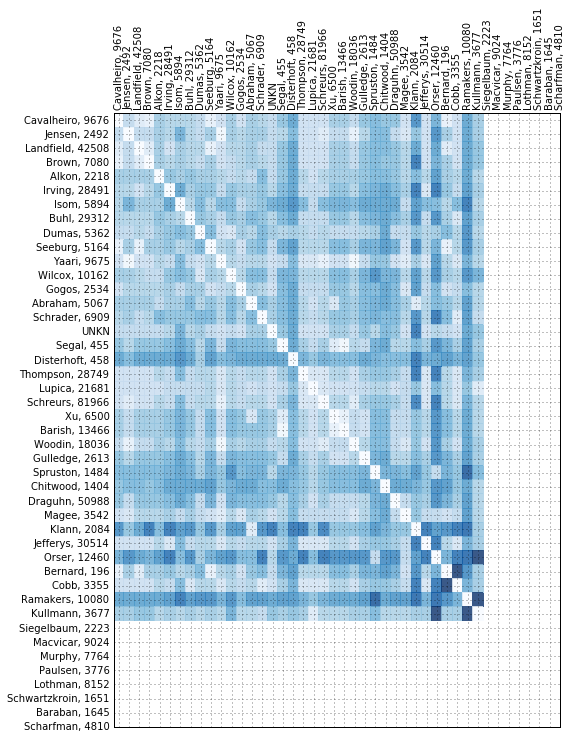

In [39]:
fig, ax = plt.subplots()
heatmap = ax.pcolor(min_df, cmap=plt.cm.Blues, alpha=0.8)
#heatmap = ax.imshow(path_df, cmap=plt.cm.Blues, alpha=0.8)
fig = plt.gcf()
fig.set_size_inches(8,11)

# turn off the frame
#ax.set_frame_on(False)

# put the major ticks at the middle of each cell
ax.set_yticks(np.arange(path_df.shape[0])+0.5, minor=False)
ax.set_xticks(np.arange(path_df.shape[1])+0.5, minor=False)

# want a more natural, table-like display
ax.invert_yaxis()
ax.xaxis.tick_top()

labels = sorted_author_last_names
ax.set_xticklabels(labels, minor=False) 
ax.set_yticklabels(labels, minor=False) 


# rotate the 
plt.xticks(rotation=90)

ax.grid(True)

# Turn off all the ticks
ax = plt.gca()

for t in ax.xaxis.get_major_ticks(): 
    t.tick1On = False 
    t.tick2On = False 
for t in ax.yaxis.get_major_ticks(): 
    t.tick1On = False 
    t.tick2On = False  



In [40]:
import pandas as pd
from pandas_ply import install_ply, X, sym_call

install_ply(pd)


In [53]:
df[df['Pmid'].isin(valid_pmids)].groupby('Pmid').head()

,Index,index,Title,Pmid,PubYear,LastAuthor,ArticleID,TableID,NeuronName,NeuronLongName,...,surfarea_sd,mahpdur,mahpdur_err,mahpdur_n,mahpdur_sd,adpdur,adpdur_err,adpdur_n,adpdur_sd,NeuroTreeID
47,1245,1245,Distinct physiological and developmental prope...,24166578,2014,Xu X,91866,45942,Hippocampus CA1 pyramidal cell,proximal CA1 pyramidal excitatory neuron,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
48,1244,1244,Distinct physiological and developmental prope...,24166578,2014,Xu X,91866,45942,Hippocampus CA2 pyramidal neuron,Hippocampus CA2 excitatory pyramidal neuron,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
49,1246,1246,Distinct physiological and developmental prope...,24166578,2014,Xu X,91866,45942,Hippocampus CA3 pyramidal cell,Distal CA3 excitatory pyramidal neuron,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
88,958,958,Modulation of BK channels contributes to activ...,25628536,2014,Schrader LA,85655,27524,Hippocampus CA1 pyramidal cell,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
89,959,959,Modulation of BK channels contributes to activ...,25628536,2014,Schrader LA,85655,27524,Hippocampus CA1 pyramidal cell,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
90,960,960,Modulation of BK channels contributes to activ...,25628536,2014,Schrader LA,85655,27524,Hippocampus CA1 pyramidal cell,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
91,961,961,Modulation of BK channels contributes to activ...,25628536,2014,Schrader LA,85655,27524,Hippocampus CA1 pyramidal cell,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
130,1160,1160,Learning increases intrinsic excitability of h...,23536065,2013,Disterhoft JF,92010,46329,Hippocampus CA1 oriens lacunosum moleculare ne...,Hippocampal CA1 somatostatin-positive inhibito...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
131,1159,1159,Learning increases intrinsic excitability of h...,23536065,2013,Disterhoft JF,92010,46326,Hippocampus CA1 pyramidal cell,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
173,967,967,Frequency dependence of CA3 spike phase respon...,24399930,2013,Paulsen O,85613,27445,Hippocampus CA1 pyramidal cell,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [50]:
valid_pmids

299     23177962
976     15381293
319     21160001
553     19302151
47      24166578
1009    12699792
804     16481438
765     17715197
1152    10878106
580     19675296
1266     9120553
626     18353290
402     22131424
1279     9185537
470     20510860
212     22157122
231     22367983
1234     9503336
1076    12379253
695     17291464
173     24399930
548     19261881
131     23536065
905     16192378
1068    12091536
537     19103683
1095    11287462
88      25628536
306     20014384
488     20639007
1093    11247989
365     21635953
1046    14573548
777     17884930
585     19710327
235     22423094
Name: Pmid, dtype: int64